# Hay neuron 

In [18]:
%matplotlib inline
import sys
import os
from os.path import join, expanduser

import numpy as np
import LFPy
import neuron

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Add the parent directory of brainsignals to sys.path
parent_path = expanduser('~/Documents/Master/ElectricBrainSignals-main')
sys.path.append(parent_path)

import brainsignals.neural_simulations as ns
hay_folder = expanduser('~/Documents/Master/ElectricBrainSignals-main/brainsignals/cell_models/L5bPCmodelsEH')

from scipy.stats import mannwhitneyu

# Cell function

In [2]:
def return_hay_cell(tstop, dt):
    if not os.path.isfile(join(hay_folder, 'morphologies', 'cell1.asc')):
        ns.download_hay_model()

    if not hasattr(neuron.h, "CaDynamics_E2"):
        ns.neuron.load_mechanisms(join(hay_folder, 'mod'))
    cell_params = {
        'morphology': join(hay_folder, "morphologies", "cell1.asc"),
        'templatefile': [join(hay_folder, 'models', 'L5PCbiophys3.hoc'),
                            join(hay_folder, 'models', 'L5PCtemplate.hoc')],
        'templatename': 'L5PCtemplate',
        'templateargs': join(hay_folder, 'morphologies', 'cell1.asc'),
        'passive': False,
        'nsegs_method': None,
        'dt': dt,
        'tstart': -200,
        'tstop': tstop,
        'v_init': -75,
        'celsius': 34,
        'pt3d': True,
        'lambda_f': 500,
        'nsegs_method': 'lambda_f'
    }

    cell = LFPy.TemplateCell(**cell_params)

    cell.set_rotation(x=4.729, y=-3.166)
    return cell

# Simulation properties

In [3]:
tstop_active = 500
tstop_active_and_passive = 5000
dt = 2**-4
cutoff = 20

freq1 = np.arange(1, 10, 2)
freq2 = np.arange(10, 200, 20)
freq3 = np.arange(200, 300, 5)
freq4 = np.arange(300, 2001, 50)

freq = np.concatenate((freq1, freq2, freq3, freq4))

selected_freq = [10, 50, 110, 250, 300, 500, 1500, 2000]

# Simulation function, Active hay cell, strong E-field

In [6]:
soma_amplitudes = []
plot_data = {}

def sim_active_hay_neuron(freq, tstop, dt, cutoff, local_E_field=500):

    global soma_amplitudes, plot_data
    soma_amplitudes = []
    plot_data = {}

    local_ext_pot = np.vectorize(lambda x, y, z: local_E_field * z / 1000)
    n_tsteps_ = int((tstop + cutoff) / dt + 1)
    t_ = np.arange(n_tsteps_) * dt

    # Loop over each frequency
    for f in freq:
        # Re-import the cell model
        cell = return_hay_cell(tstop, dt)
        cell.extracellular = True
    
        for sec in cell.allseclist:
            sec.insert("extracellular")
    
        # Compute base potential
        base_pot = local_ext_pot(
            cell.x.mean(axis=-1),
            cell.y.mean(axis=-1),
            cell.z.mean(axis=-1)
        ).reshape(cell.totnsegs, 1)
    
        # Generate the pulse for the current frequency
        pulse = np.sin(2 * np.pi * f * t_ / 1000)
        
        # Prepare the external potential array
        v_cell_ext = np.zeros((cell.totnsegs, n_tsteps_))
        v_cell_ext = base_pot * pulse.reshape(1, n_tsteps_)
    
        # Apply the external potential and simulate the cell
        cell.insert_v_ext(v_cell_ext, t_)
        cell.simulate(rec_vmem=True)
    
        # Calculate the amplitude of the soma potential
        # Max and min / 2 to show spiking or not spiking
        stable_time = cell.tvec[cell.tvec > 150]
        stable_vmem = cell.vmem[0, cell.tvec > 150]
        amplitude = (np.max(stable_vmem) - np.min(stable_vmem)) / 2
    
        soma_amplitudes.append(amplitude)

        # Store plot data ----
        apic_idx1 = cell.get_closest_idx(z=1000)
        apic_idx2 = cell.get_closest_idx(z=-100)
        selected_segments = [0, apic_idx1, apic_idx2]

        # Initialize dictionary for plot data
        if f == selected_freq[0]:
            plot_data = {
                "freq": [],
                "x": cell.x.tolist(),
                "z": cell.z.tolist(),
                "totnsegs": cell.totnsegs,
                "tvec": cell.tvec.tolist(),
                "selected_segments": selected_segments,
                "colors": ['tab:blue', 'tab:orange', 'tab:olive'],
                "soma_vmem": [],
                "idx1_vmem": [],
                "idx2_vmem": []
            }            

        # Store plot-data for some of the frequencies
        if f in selected_freq:
            plot_data['freq'].append(f)
            plot_data['soma_vmem'].append(cell.vmem[0].tolist())
            plot_data['idx1_vmem'].append(cell.vmem[selected_segments[1]].tolist())
            plot_data['idx2_vmem'].append(cell.vmem[selected_segments[2]].tolist())

        print(f'{f}Hz complete')
        # Delete the cell before next frequency
        del cell
    

In [7]:
sim_active_hay_neuron(freq=freq, tstop=tstop_active, dt=dt, cutoff=cutoff)

1Hz complete
3Hz complete
5Hz complete
7Hz complete
9Hz complete
10Hz complete
30Hz complete
50Hz complete
70Hz complete
90Hz complete
110Hz complete
130Hz complete
150Hz complete
170Hz complete
190Hz complete
200Hz complete
205Hz complete
210Hz complete
215Hz complete
220Hz complete
225Hz complete
230Hz complete
235Hz complete
240Hz complete
245Hz complete
250Hz complete
255Hz complete
260Hz complete
265Hz complete
270Hz complete
275Hz complete
280Hz complete
285Hz complete
290Hz complete
295Hz complete
300Hz complete
350Hz complete
400Hz complete
450Hz complete
500Hz complete
550Hz complete
600Hz complete
650Hz complete
700Hz complete
750Hz complete
800Hz complete
850Hz complete
900Hz complete
950Hz complete
1000Hz complete
1050Hz complete
1100Hz complete
1150Hz complete
1200Hz complete
1250Hz complete
1300Hz complete
1350Hz complete
1400Hz complete
1450Hz complete
1500Hz complete
1550Hz complete
1600Hz complete
1650Hz complete
1700Hz complete
1750Hz complete
1800Hz complete
1850Hz c

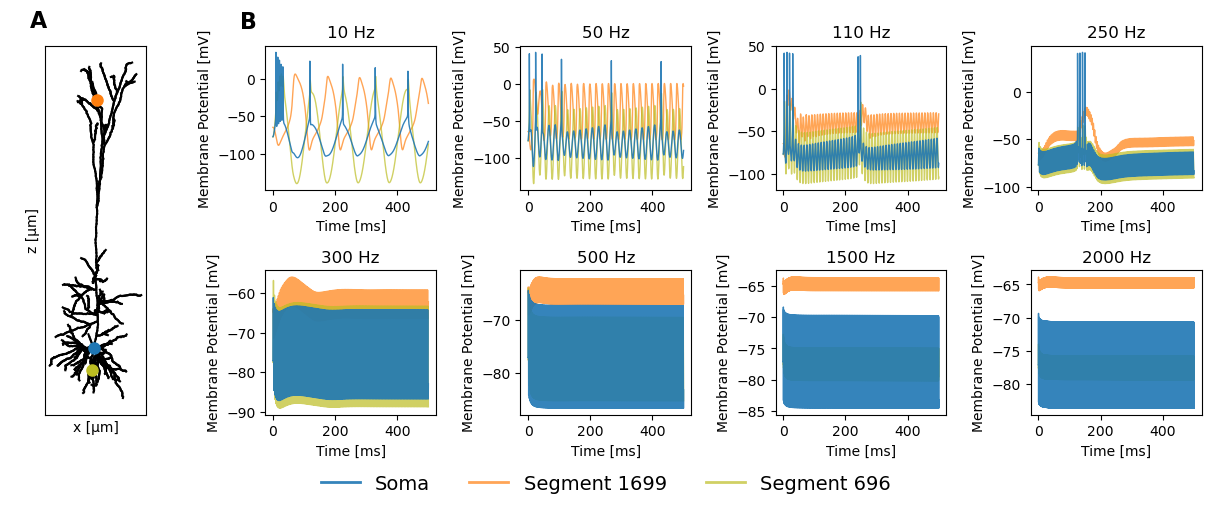

In [8]:
def plot_vmem(plot_data):
    numrows = 2
    numcols = len(plot_data['freq']) // 2 + 1  # +1 for morphology column

    # Use constrained_layout and GridSpec for control
    fig = plt.figure(figsize=(12, 5), constrained_layout=True)
    gs = GridSpec(3, numcols, figure=fig, height_ratios=[10, 10, 1])  # 2 rows of plots + 1 row for legend

    axes = np.empty((2, numcols), dtype=object)  # Placeholder for axes refs

    # Plot A: Morphology (rowspan 2, col 0)
    ax1 = fig.add_subplot(gs[0:2, 0])
    ax1.set_aspect(1)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_xlabel('x [µm]')
    ax1.set_ylabel('z [µm]')

    totnsegs = int(plot_data['totnsegs'])
    x = np.array(plot_data['x'])
    z = np.array(plot_data['z'])
    selected_segments = plot_data['selected_segments']
    colors = ['tab:blue', 'tab:orange', 'tab:olive']

    for idx_seg in range(totnsegs):
        ax1.plot(x[idx_seg], z[idx_seg], c='k')

    for idx, color in zip(selected_segments, colors):
        ax1.plot(x.mean(axis=-1)[idx], z.mean(axis=-1)[idx], 'o', color=color, label=f"Segment {idx}", markersize = 8)

    ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold')

    # Plot B: Membrane potentials
    tvec = np.array(plot_data['tvec'])
    soma_vmem = np.array(plot_data['soma_vmem'])
    idx1_vmem = np.array(plot_data['idx1_vmem'])
    idx2_vmem = np.array(plot_data['idx2_vmem'])

    for i, f in enumerate(plot_data['freq']):
        row = i // (numcols - 1)
        col = (i % (numcols - 1)) + 1  # +1 because col 0 is morphology

        ax = fig.add_subplot(gs[row, col])
        axes[row, col] = ax

        ax.set_xlabel('Time [ms]')
        ax.set_ylabel('Membrane Potential [mV]')
        ax.set_title(f"{f} Hz", fontsize=12)

        ax.plot(tvec, idx1_vmem[i], color=colors[1], label=f'Segment {selected_segments[1]}', linewidth=1, alpha=0.7)
        ax.plot(tvec, idx2_vmem[i], color=colors[2], label=f'Segment {selected_segments[2]}', linewidth=1, alpha=0.7)
        ax.plot(tvec, soma_vmem[i], color=colors[0], label='Soma', linewidth=1, alpha=0.9)

        if row == 0 and col == 1:
            ax.text(-0.15, 1.12, 'B', transform=ax.transAxes, fontsize=16, fontweight='bold')

    # Legend (bottom row, spanning all columns)
    legend_ax = fig.add_subplot(gs[2, :])
    legend_ax.axis('off')

    handles = [
        plt.Line2D([0], [0], color=colors[0], label='Soma', linewidth=2, alpha=0.9),
        plt.Line2D([0], [0], color=colors[1], label=f'Segment {selected_segments[1]}', linewidth=2, alpha=0.7),
        plt.Line2D([0], [0], color=colors[2], label=f'Segment {selected_segments[2]}', linewidth=2, alpha=0.7)
    ]
    legend_ax.legend(handles=handles, loc='center', ncol=3, frameon=False, fontsize = 14)

    plt.savefig('Hay_cell_active_cell_shape_and_vmem_plots.png', dpi=300)
    plt.show()
plot_vmem(plot_data)

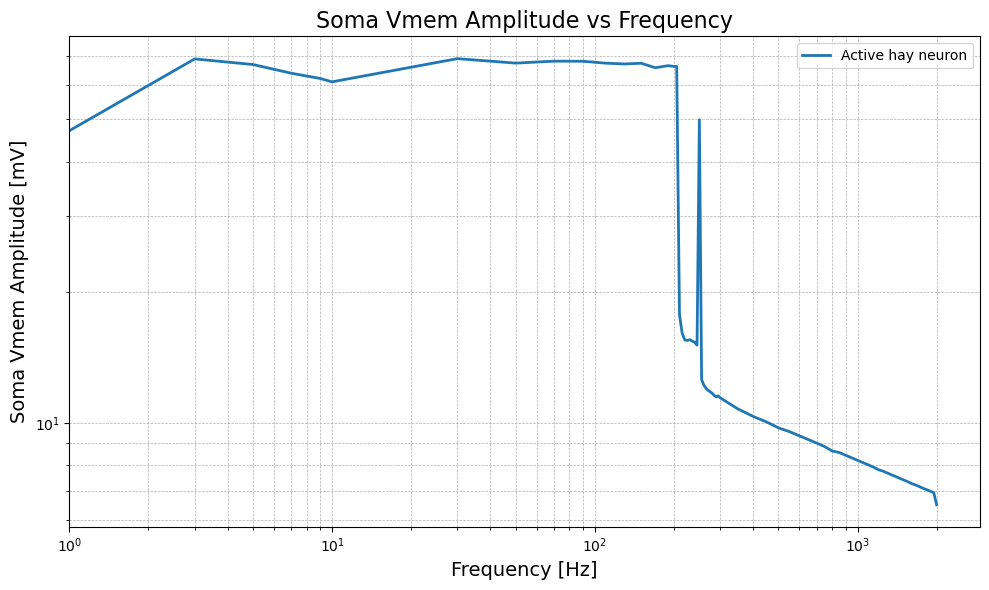

In [9]:
# Amplitudes found via max-min, and represent firing. Real amplitude with same frequency as stimulation frequency differs from this
plt.figure(figsize=(10, 6))  # Set the figure size
plt.loglog(freq, soma_amplitudes, linestyle='-', color='tab:blue', markersize=5, linewidth=2, label = 'Active hay neuron')
plt.xlabel('Frequency [Hz]', fontsize=14)
plt.ylabel('Soma Vmem Amplitude [mV]', fontsize=14)
plt.legend()
plt.title('Soma Vmem Amplitude vs Frequency', fontsize=16)
plt.xlim(left=1)  # Start the x-axis from 2
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout() 
plt.savefig('Hay_cell_active_soma_amp_vs_freq')
plt.show()

# Simulation function, Active and Passive hay cell, weaker E-field

In [11]:
soma_amplitudes_active = []
soma_amplitudes_passive = []
plot_data_both = {}

remove_list = ["Ca_HVA", "Ca_LVAst", "CaDynamics_E2", "epsp2", "Ih", "Im", "K_Pst", "K_Tst", "Nap_Et2", "NaTa_t", "NaTs2_t", "SK_E2", "SKv3_1"]


def sim_a_and_p_hay_neuron(freq, tstop, dt, cutoff, local_E_field=1):

    global soma_amplitudes_active, soma_amplitudes_passive, plot_data_both
    soma_amplitudes_active = []
    soma_amplitudes_passive = []
    plot_data_both = {}

    local_ext_pot = np.vectorize(lambda x, y, z: local_E_field * z / 1000)
    n_tsteps_ = int((tstop + cutoff) / dt + 1)
    t_ = np.arange(n_tsteps_) * dt

    hay_cells = ['Active', 'Passive']

    for cell_idx in range(len(hay_cells)):
        cell_type = hay_cells[cell_idx]
                 
        # Loop over each frequency
        for f in freq:
            # Re-import the cell model for each frequency
            
            if cell_type == 'Active':
                cell = return_hay_cell(tstop, dt)
            if cell_type == 'Passive':
                cell = return_hay_cell(tstop, dt)
                ns.remove_active_mechanisms(remove_list, cell)
                
            cell.extracellular = True
        
            for sec in cell.allseclist:
                sec.insert("extracellular")
        
            # Compute base potential
            base_pot = local_ext_pot(
                cell.x.mean(axis=-1),
                cell.y.mean(axis=-1),
                cell.z.mean(axis=-1)
            ).reshape(cell.totnsegs, 1)
        
            # Generate the pulse for the current frequency
            pulse = np.sin(2 * np.pi * f * t_ / 1000)
            
            # Prepare the external potential array
            v_cell_ext = np.zeros((cell.totnsegs, n_tsteps_))
            v_cell_ext = base_pot * pulse.reshape(1, n_tsteps_)
        
            # Apply the external potential and simulate the cell
            cell.insert_v_ext(v_cell_ext, t_)
            cell.simulate(rec_vmem=True)
        
            # Calculate the amplitude of the soma potential
            cut_tvec = cell.tvec[cell.tvec > 2000]
            cut_soma_vmem = cell.vmem[0, cell.tvec > 2000]
            freqs, vmem_amps = ns.return_freq_and_amplitude(cut_tvec, cut_soma_vmem)
            freq_idx = np.argmin(np.abs(freqs - f))
            soma_amp = vmem_amps[0, freq_idx]
            print(f'freq from ff: {freqs[freq_idx]}, actual freq: {f}')
            print(f'amp from ff: {soma_amp}, fom max-min/2 {(np.max(cut_soma_vmem) - np.min(cut_soma_vmem)) / 2}')

            if cell_type == 'Active':
                soma_amplitudes_active.append(soma_amp)
            if cell_type == 'Passive':
                soma_amplitudes_passive.append(soma_amp)
                
    
            # Initialize dictionary for plot data 
            if f == selected_freq[0]:
                plot_data_both[cell_type] = {
                    "freq": [],
                    "x": cell.x.tolist(),
                    "z": cell.z.tolist(),
                    "totnsegs": cell.totnsegs,
                    "tvec": cell.tvec.tolist(),
                    "selected_segments": [0, cell.get_closest_idx(z=1000), cell.get_closest_idx(z=-100)],
                    "colors": ['tab:blue', 'tab:orange', 'tab:green'],
                    "soma_vmem": [],
                    "idx1_vmem": [],
                    "idx2_vmem": []
                }            
    
            # Store plot-data for some of the frequencies
            if f in selected_freq:
                plot_data_both[cell_type]['freq'].append(f)
                plot_data_both[cell_type]['soma_vmem'].append(cell.vmem[0].tolist())
                plot_data_both[cell_type]['idx1_vmem'].append(cell.vmem[cell.get_closest_idx(z=1000)].tolist())
                plot_data_both[cell_type]['idx2_vmem'].append(cell.vmem[cell.get_closest_idx(z=-100)].tolist())

            print(f'{f}Hz complete for {cell_type}')
            # Delete the cell before next frequency
            del cell
        print(f'Simulation for {cell_type} hay cell complete')

In [12]:
sim_a_and_p_hay_neuron(freq=freq, tstop=tstop_active_and_passive, dt=dt, cutoff=cutoff)

freq from ff: 1.0, actual freq: 1
amp from ff: 0.2092056600062792, fom max-min/2 0.20977776670090265
1Hz complete for Active
freq from ff: 3.0, actual freq: 3
amp from ff: 0.22118488694408117, fom max-min/2 0.22229732312722916
3Hz complete for Active
freq from ff: 5.0, actual freq: 5
amp from ff: 0.2156045282868317, fom max-min/2 0.21684016167723286
5Hz complete for Active
freq from ff: 7.0, actual freq: 7
amp from ff: 0.19501705887844398, fom max-min/2 0.19630397218201523
7Hz complete for Active
freq from ff: 9.0, actual freq: 9
amp from ff: 0.174252192479984, fom max-min/2 0.17556813760367618
9Hz complete for Active
freq from ff: 10.0, actual freq: 10
amp from ff: 0.1657801422018538, fom max-min/2 0.16710690503336423
10Hz complete for Active
freq from ff: 30.0, actual freq: 30
amp from ff: 0.09532185248497264, fom max-min/2 0.09672062251098623
30Hz complete for Active
freq from ff: 50.0, actual freq: 50
amp from ff: 0.0671143877150779, fom max-min/2 0.06853057771451887
50Hz complete 

### Plot differences

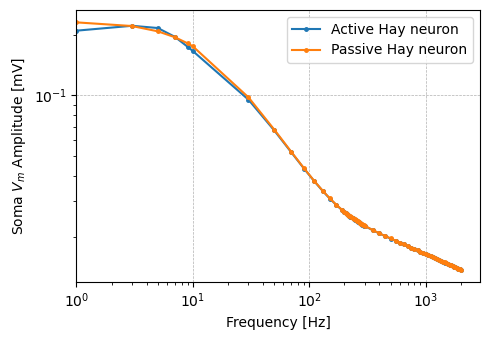

In [19]:
plt.figure(figsize=(5, 3.5))  # Set the figure size
plt.loglog(freq, soma_amplitudes_active, linestyle='-', color='tab:blue', markersize=5, linewidth=1.5, label = 'Active Hay neuron', marker = '.')
plt.loglog(freq, soma_amplitudes_passive, linestyle='-', color='tab:orange', markersize=5, linewidth=1.5, label = 'Passive Hay neuron', marker = '.')
plt.xlabel('Frequency [Hz]', fontsize=10)
plt.ylabel(r'Soma $V_m$ Amplitude [mV]', fontsize=10)
plt.legend()
plt.xlim(left=1)  # Start the x-axis from 1
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout() 
plt.savefig('Hay_cell_active_and_passive_soma_amp_vs_freq')
plt.show()

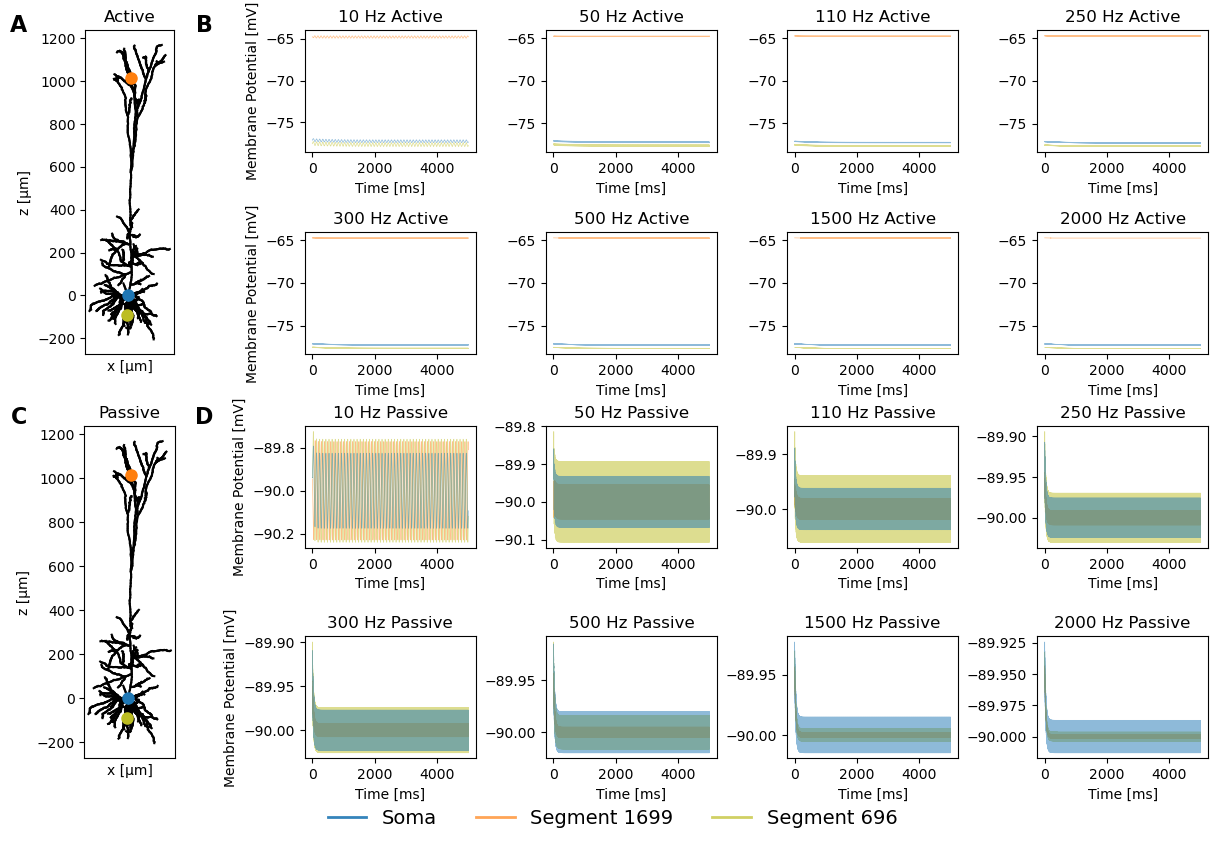

In [14]:

def plot_vmem_both(plot_data_both):
    numrows = 4  # Two for Active, two for Passive
    numcols = len(plot_data_both['Active']['freq']) // 2 + 1
    fig, axes = plt.subplots(numrows, numcols, figsize=(12, 8), gridspec_kw={'height_ratios': [1, 1, 1, 1], 'width_ratios': [1] * numcols})

    for row in range(numrows):
        axes[row,0].set_xticks([])
        axes[row,0].set_yticks([])
        axes[row,0].set_frame_on(False)

    conditions = ['Active', 'Passive']

    # Add label A and C above morphology plots
    fig.text(0.005, 0.99, 'A', fontsize=16, fontweight='bold', va='top', ha='center')
    fig.text(0.005, 0.5, 'C', fontsize=16, fontweight='bold', va='top', ha='center')
    
    # Add label B and D above the membrane potential plots
    fig.text(0.16, 0.99, 'B', fontsize=16, fontweight='bold', va='top', ha='center')
    fig.text(0.16, 0.5, 'D', fontsize=16, fontweight='bold', va='top', ha='center')
    
    for condition_idx, condition in enumerate(conditions):
        plot_data = plot_data_both[condition]

        # Extract data
        selected_segments = plot_data['selected_segments']
        #colors = plot_data['colors']
        colors = ['tab:blue', 'tab:orange', 'tab:olive']
        totnsegs = int(plot_data['totnsegs'])
        x = np.array(plot_data['x'])
        z = np.array(plot_data['z'])
        tvec = np.array(plot_data['tvec'])
        soma_vmem = np.array(plot_data['soma_vmem'])
        idx1_vmem = np.array(plot_data['idx1_vmem'])
        idx2_vmem = np.array(plot_data['idx2_vmem'])

        # Define the starting row index (0 for Active, 2 for Passive)
        start_row = condition_idx * 2

        # First column: Cell shape
        ax1 = plt.subplot2grid((numrows, numcols), (start_row, 0), rowspan=2)
        ax1.set_aspect(1)
        ax1.set_xticks([])
        ax1.set_xlabel('x [µm]')
        ax1.set_ylabel('z [µm]')
        ax1.set_title(f'{condition}')

        for idx_seg in range(totnsegs):
            ax1.plot(x[idx_seg], z[idx_seg], c='k')

        for idx, color in zip(selected_segments, colors):
            ax1.plot(x.mean(axis=-1)[idx], z.mean(axis=-1)[idx], 'o', color=color, label=f"Segment {idx}", markersize = 8)

        # Remaining columns: Membrane potential over time for each frequency
        for i, f in enumerate(plot_data['freq']):
            row = start_row + (i // 4)  # Distribute over two rows per condition
            col = (i % 4) + 1
            ax = axes[row, col]

            ax.set_xlabel('Time [ms]')
            if col == 1:
                ax.set_ylabel('Membrane Potential [mV]')
            ax.set_title(f"{f} Hz {condition}")

            ax.plot(tvec, idx1_vmem[i], color=colors[1], label=f'Segment {plot_data['selected_segments'][1]}', linewidth=0.5, alpha=0.5)
            ax.plot(tvec, idx2_vmem[i], color=colors[2], label=f'Segment {plot_data['selected_segments'][2]}', linewidth=0.5, alpha=0.5)
            ax.plot(tvec, soma_vmem[i], color=colors[0], label='Soma', linewidth=0.5, alpha=0.5)

    # Create a common legend underneath all plots
    handles = [
        plt.Line2D([0], [0], color=colors[0], label='Soma', linewidth=2, alpha=0.9),
        plt.Line2D([0], [0], color=colors[1], label=f'Segment {selected_segments[1]}', linewidth=2, alpha=0.7),
        plt.Line2D([0], [0], color=colors[2], label=f'Segment {selected_segments[2]}', linewidth=2, alpha=0.7)
    ]

    fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3, frameon=False, fontsize = 14)

    fig.set_constrained_layout(True)
    plt.savefig('Hay_cell_active_vs_passive_cell_shape_and_vmem_plots')
    plt.show()


plot_vmem_both(plot_data_both)


## Mann-Whitney U 

In [17]:
mw_12_stat, mw_12_p = mannwhitneyu(soma_amplitudes_active, soma_amplitudes_passive, alternative='two-sided')

print(f"Mann-Whitney U Test (Data1 vs Data2) (with remove_list and fourier): U={mw_12_stat}, p={mw_12_p}")

Mann-Whitney U Test (Data1 vs Data2) (with remove_list and fourier): U=2416.0, p=0.8889652671902902
